In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


# STEP 0 : Importing Libraries

In [2]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
from scipy.stats import skew
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures,StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import  KFold, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV,train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score, classification_report
from catboost import CatBoostClassifier,Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
import gc

import warnings
warnings.filterwarnings("ignore")

# STEP 1: Loading the dataset

In [3]:
#Loading the Dataset
train_df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')


print('Shape of train data is : ' , train_df.shape)
print('train data columns: ' , train_df.columns)

Shape of train data is :  (11504798, 12)
train data columns:  Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


# STEP 2: Data Understanding

In [4]:
print('train data columns: ' , train_df
      .columns)

train data columns:  Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


In [5]:
train_df['Gender'].value_counts()

Gender
Male      6228134
Female    5276664
Name: count, dtype: int64

In [6]:
train_df['Driving_License'].value_counts()

Driving_License
1    11482041
0       22757
Name: count, dtype: int64

In [7]:
train_df['Region_Code'].value_counts()

Region_Code
28.0    3451062
8.0     1021036
46.0     578208
41.0     557581
15.0     403977
30.0     367307
29.0     338146
50.0     302334
11.0     278261
36.0     261946
3.0      246303
33.0     232387
47.0     229190
35.0     200035
6.0      181122
45.0     159292
37.0     158976
18.0     148548
39.0     138068
14.0     134585
21.0     126793
10.0     126081
2.0      118097
48.0     114230
13.0     108838
9.0       93371
7.0       92240
12.0      92142
27.0      78878
32.0      78797
43.0      75868
17.0      74533
26.0      71228
25.0      70556
24.0      69136
38.0      60587
0.0       59274
20.0      58765
31.0      58442
16.0      54905
23.0      54518
4.0       52504
49.0      50822
34.0      48685
19.0      44197
22.0      36932
5.0       36832
40.0      35888
1.0       33966
44.0      20305
42.0      13693
52.0       3450
51.0       1880
39.2          1
Name: count, dtype: int64

In [8]:
train_df['Age'].value_counts()

Age
24    815884
23    750298
22    661236
25    635677
21    503310
       ...  
81       306
82       170
83        81
84        35
85         9
Name: count, Length: 66, dtype: int64

In [9]:
train_df['Previously_Insured'].value_counts()

Previously_Insured
0    6178116
1    5326682
Name: count, dtype: int64

In [10]:
train_df['Vehicle_Age'].value_counts()

Vehicle_Age
1-2 Year     5982678
< 1 Year     5044145
> 2 Years     477975
Name: count, dtype: int64

In [11]:
train_df['Vehicle_Damage'].value_counts()

Vehicle_Damage
Yes    5783229
No     5721569
Name: count, dtype: int64

In [12]:
train_df['Annual_Premium'].value_counts()

Annual_Premium
2630.0     2112561
38287.0       6363
39008.0       5285
38452.0       4721
28861.0       4671
            ...   
70546.0          1
71347.0          1
17515.0          1
76928.0          1
61836.0          1
Name: count, Length: 51728, dtype: int64

In [13]:
train_df['Policy_Sales_Channel'].value_counts()

Policy_Sales_Channel
152.0    4166183
26.0     2433456
124.0    2264490
160.0     640380
156.0     316693
          ...   
102.0          4
112.0          3
27.0           2
6.0            1
5.0            1
Name: count, Length: 152, dtype: int64

In [14]:
train_df['Vintage'].value_counts()

Vintage
187    98018
282    96377
131    91892
256    90945
232    85183
       ...  
25     16289
26     16182
32     15460
41     15359
50     14002
Name: count, Length: 290, dtype: int64

In [15]:
train_df['Response'].value_counts()

Response
0    10089739
1     1415059
Name: count, dtype: int64

In [16]:
train_df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,5.752398e+06,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,3.321149e+06,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.876199e+06,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,5.752398e+06,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,8.628598e+06,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,1.150480e+07,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


In [17]:
# Type dados
train_df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [18]:
# Viewing rows and columns
train_df.shape

(11504798, 12)

# STEP 3: Data Analysis

In [19]:
# Exploratory data analysis (EDA)
print("\nDescriptive statistics of the training set:")
train_df.describe().T


Descriptive statistics of the training set:


,count,mean,std,min,25%,50%,75%,max
id,11504798.0,5.752398e+06,3.321149e+06,0.0,2876199.25,5752398.5,8628597.75,11504797.0
Age,11504798.0,3.838356e+01,1.499346e+01,20.0,24.00,36.0,49.00,85.0
Driving_License,11504798.0,9.980220e-01,4.443120e-02,0.0,1.00,1.0,1.00,1.0
Region_Code,11504798.0,2.641869e+01,1.299159e+01,0.0,15.00,28.0,35.00,52.0
Previously_Insured,11504798.0,4.629966e-01,4.986289e-01,0.0,0.00,0.0,1.00,1.0
Annual_Premium,11504798.0,3.046137e+04,1.645475e+04,2630.0,25277.00,31824.0,39451.00,540165.0
Policy_Sales_Channel,11504798.0,1.124254e+02,5.403571e+01,1.0,29.00,151.0,152.00,163.0
Vintage,11504798.0,1.638977e+02,7.997953e+01,10.0,99.00,166.0,232.00,299.0
Response,11504798.0,1.229973e-01,3.284341e-01,0.0,0.00,0.0,0.00,1.0


In [20]:
# Identify categorical and numerical features
categorical_features = train_df.select_dtypes(include=['object']).columns
numerical_features = train_df.select_dtypes(include=[np.number]).columns

print("\nCategorical Variables:", list(categorical_features))
print("Numeric Variables:", list(numerical_features))

# Analysis of categorical variables
for col in categorical_features:
    print(f"\nDistribution of categorical variable '{col}':")
    print(train_df[col].value_counts())


Categorical Variables: ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
Numeric Variables: ['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']

Distribution of categorical variable 'Gender':
Gender
Male      6228134
Female    5276664
Name: count, dtype: int64

Distribution of categorical variable 'Vehicle_Age':
Vehicle_Age
1-2 Year     5982678
< 1 Year     5044145
> 2 Years     477975
Name: count, dtype: int64

Distribution of categorical variable 'Vehicle_Damage':
Vehicle_Damage
Yes    5783229
No     5721569
Name: count, dtype: int64


In [21]:

# Analysis of categorical variables
for col in categorical_features:
    print(f"\nDistribution of categorical variable {col}:")
    print(train_df[col].value_counts())


Distribution of categorical variable Gender:
Gender
Male      6228134
Female    5276664
Name: count, dtype: int64

Distribution of categorical variable Vehicle_Age:
Vehicle_Age
1-2 Year     5982678
< 1 Year     5044145
> 2 Years     477975
Name: count, dtype: int64

Distribution of categorical variable Vehicle_Damage:
Vehicle_Damage
Yes    5783229
No     5721569
Name: count, dtype: int64


STEP 4: Exploratory Data Analysis# STEP 4: Exploratory Data Analysis

Response
0    10089739
1     1415059
Name: count, dtype: int64


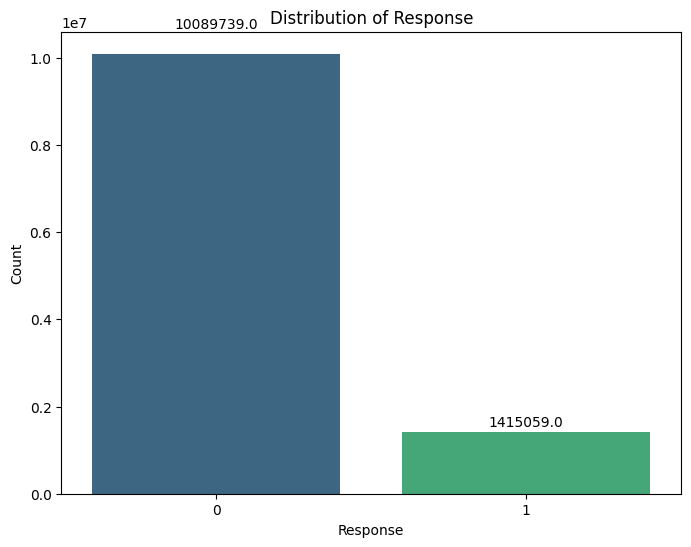

In [22]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=train_df, x='Response', palette='viridis')
print(train_df['Response'].value_counts())
# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.05 * height, f'{height}', ha='center', va='bottom')

plt.title("Distribution of Response")
plt.xlabel('Response')
plt.ylabel('Count')
plt.grid(False)
plt.show()

Gender
Male      6228134
Female    5276664
Name: count, dtype: int64


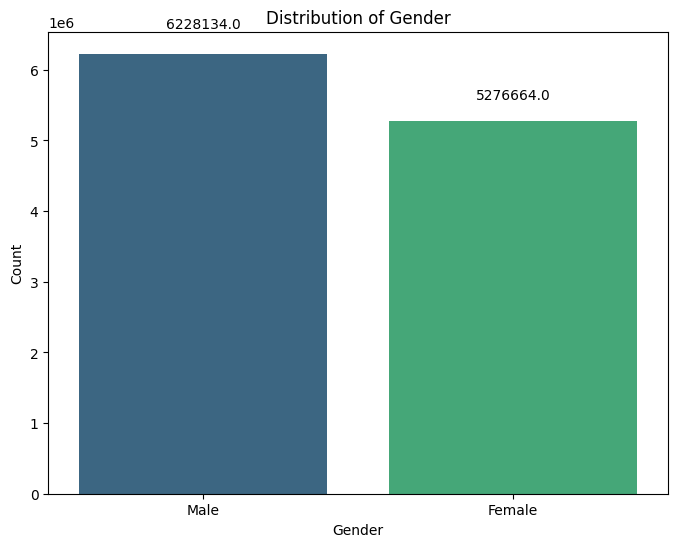

In [23]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=train_df, x='Gender',palette='viridis')
print(train_df['Gender'].value_counts())
# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.05 * height, f'{height}', ha='center', va='bottom')

plt.title("Distribution of Gender")
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(False)
plt.show()

Vehicle_Age
1-2 Year     5982678
< 1 Year     5044145
> 2 Years     477975
Name: count, dtype: int64


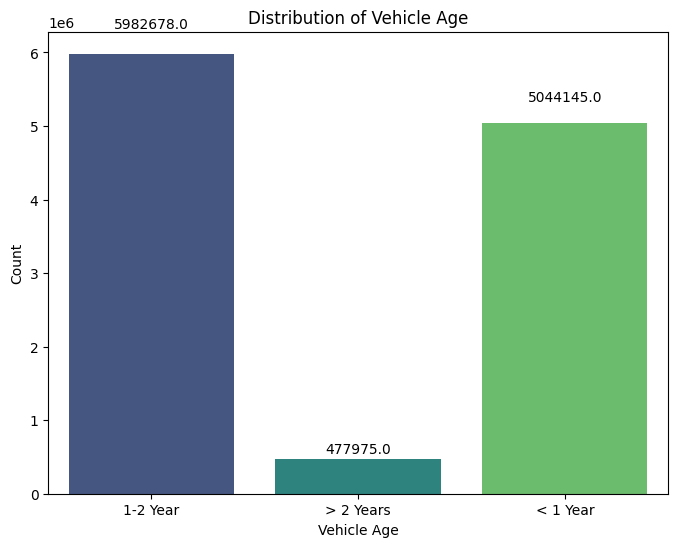

In [24]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=train_df, x='Vehicle_Age',palette='viridis')
print(train_df['Vehicle_Age'].value_counts())
# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.05 * height, f'{height}', ha='center', va='bottom')

plt.title("Distribution of Vehicle Age")
plt.xlabel('Vehicle Age')
plt.ylabel('Count')
plt.grid(False)
plt.show()

Vehicle_Damage
Yes    5783229
No     5721569
Name: count, dtype: int64


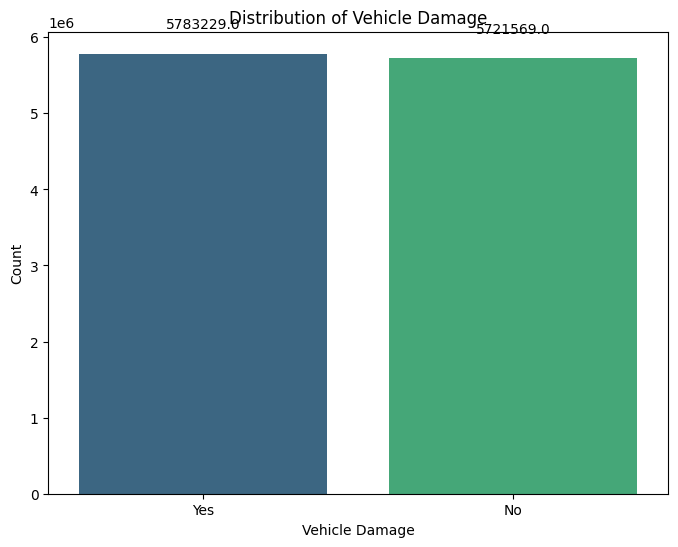

In [25]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=train_df, x='Vehicle_Damage', palette='viridis')
print(train_df['Vehicle_Damage'].value_counts())
# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.05 * height, f'{height}', ha='center', va='bottom')

plt.title("Distribution of Vehicle Damage")
plt.xlabel('Vehicle Damage')
plt.ylabel('Count')
plt.grid(False)
plt.show()

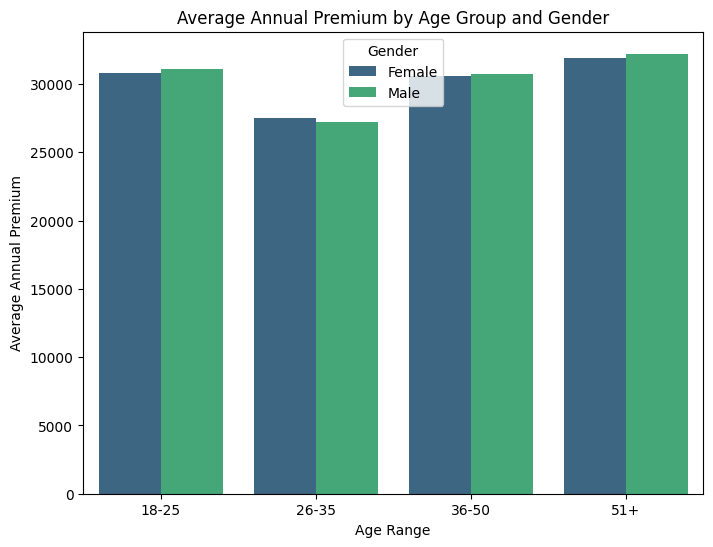

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Example DataFrame setup (assuming train_df is already defined)
# Create age ranges
train_df['Age_Bucket'] = pd.cut(train_df['Age'], bins=[18, 25, 35, 50, np.inf], labels=['18-25', '26-35', '36-50', '51+'])

# Group data by age group and gender, and calculate the average annual premium for each group
average_premium_by_age_gender = train_df.groupby(['Age_Bucket', 'Gender'])['Annual_Premium'].mean().reset_index()

# View the average annual premium by age group and gender
plt.figure(figsize=(8, 6))
sns.barplot(x='Age_Bucket', y='Annual_Premium', hue='Gender', data=average_premium_by_age_gender, palette='viridis')

plt.title('Average Annual Premium by Age Group and Gender')
plt.xlabel('Age Range')
plt.ylabel('Average Annual Premium')
plt.legend(title='Gender')
plt.grid(False)
plt.show()


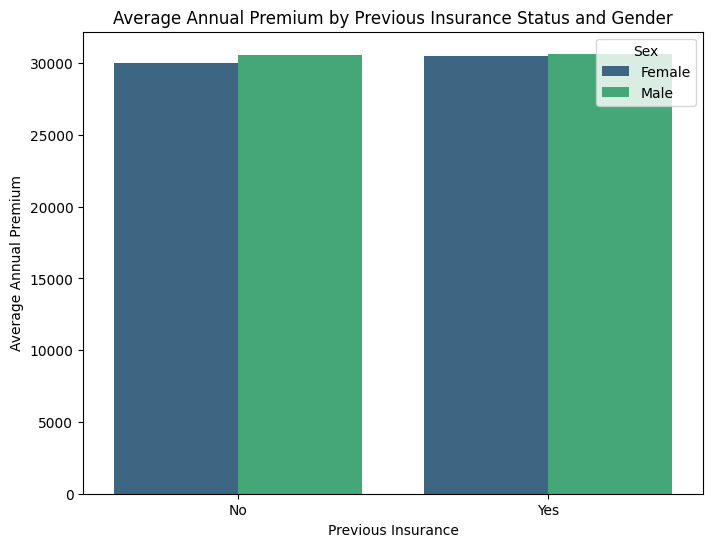

In [27]:

# Group data by gender and previous insurance status, and calculate the average annual premium for each group
average_premium_by_gender_insured = train_df.groupby(['Gender', 'Previously_Insured'])['Annual_Premium'].mean().reset_index()

# Transform the 'Previously_Insured' variable into a more readable category
average_premium_by_gender_insured['Previously_Insured'] = average_premium_by_gender_insured['Previously_Insured'].map({0: 'No', 1: 'Yes'})

# View average annual premium by gender and previous insurance status
plt.figure(figsize=(8, 6))
sns.barplot(x='Previously_Insured', y='Annual_Premium', hue='Gender', data=average_premium_by_gender_insured, palette='viridis')
plt.title('Average Annual Premium by Previous Insurance Status and Gender')
plt.xlabel('Previous Insurance')
plt.ylabel('Average Annual Premium')
plt.legend(title='Sex')
plt.grid(False)
plt.show()

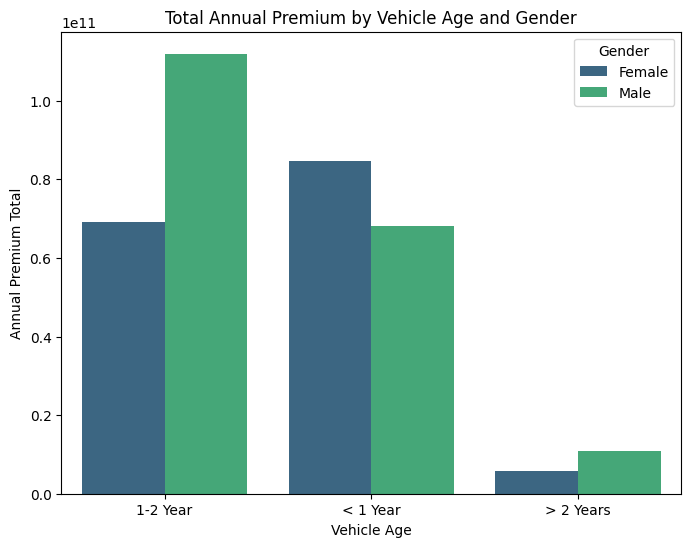

In [28]:
# Group by vehicle age and gender, adding annual premiums
grouped_data = train_df.groupby(['Vehicle_Age', 'Gender'])['Annual_Premium'].sum().reset_index()

# Grouped bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=grouped_data, x='Vehicle_Age', y='Annual_Premium', hue='Gender', palette='viridis')

plt.title('Total Annual Premium by Vehicle Age and Gender')
plt.xlabel('Vehicle Age')
plt.ylabel('Annual Premium Total')
plt.legend(title='Gender')
plt.grid(False)
plt.show()

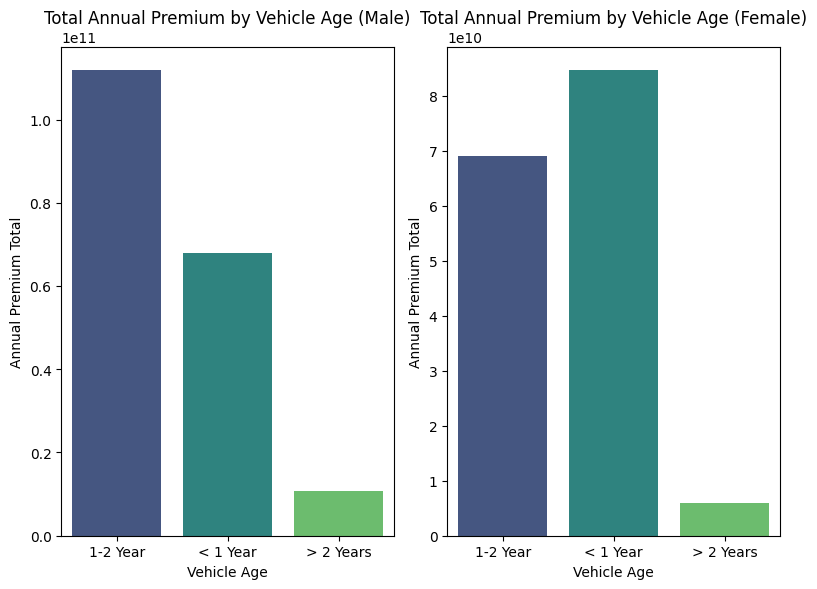

In [29]:
# List of genders
genders = train_df['Gender'].unique()

# Figure size
plt.figure(figsize=(8, 6))

# Loop over genders
for i, gender in enumerate(genders, 1):
    plt.subplot(1, len(genders), i)  # Adjust subplot grid based on the number of genders
    gender_data = train_df[train_df['Gender'] == gender]
    gender_grouped = gender_data.groupby('Vehicle_Age')['Annual_Premium'].sum().reset_index()
    sns.barplot(data=gender_grouped, x='Vehicle_Age', y='Annual_Premium', palette='viridis')
    plt.title(f'Total Annual Premium by Vehicle Age ({gender})')
    plt.xlabel('Vehicle Age')
    plt.ylabel('Annual Premium Total')

plt.tight_layout()
plt.grid(False)
plt.show()

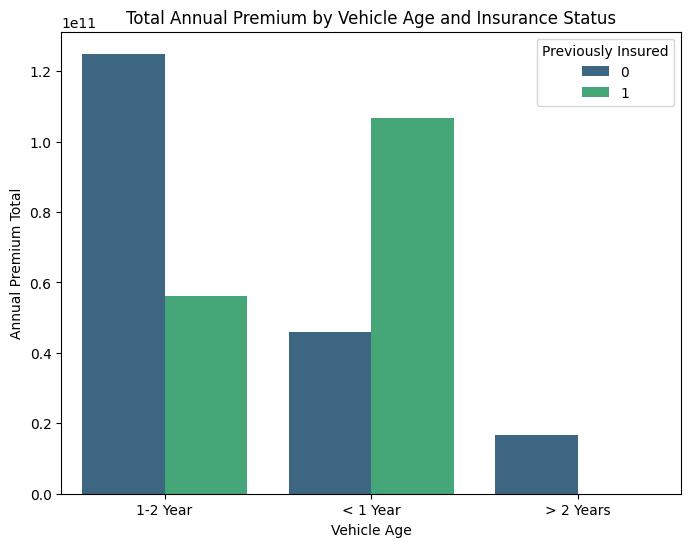

In [30]:
# Group by vehicle age and insurance status, adding annual premiums
grouped_data = train_df.groupby(['Vehicle_Age', 'Previously_Insured'])['Annual_Premium'].sum().reset_index()

# Convert the 'Previously_Insured' column to string for better visualization
grouped_data['Previously_Insured'] = grouped_data['Previously_Insured'].astype(str)

# Grouped bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=grouped_data, x='Vehicle_Age', y='Annual_Premium', hue='Previously_Insured', palette='viridis')
plt.title('Total Annual Premium by Vehicle Age and Insurance Status')
plt.xlabel('Vehicle Age')
plt.ylabel('Annual Premium Total')
plt.legend(title='Previously Insured')
plt.grid(False)
plt.show()

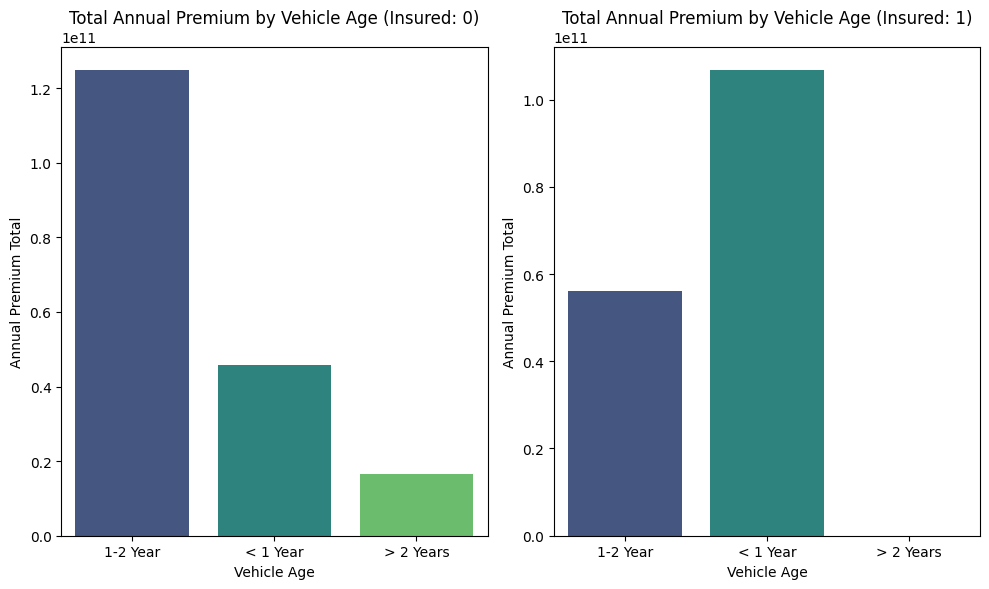

In [31]:
# List of insurance statuses
statuses = train_df['Previously_Insured'].unique()

# Figure size: Adjust number of columns dynamically based on the number of statuses
plt.figure(figsize=(10, 6))

# Loop over insurance statuses
for i, status in enumerate(statuses, 1):
    plt.subplot(1, len(statuses), i)  # Adjust subplot grid based on the number of statuses
    status_data = train_df[train_df['Previously_Insured'] == status]
    status_grouped = status_data.groupby('Vehicle_Age')['Annual_Premium'].sum().reset_index()
    sns.barplot(data=status_grouped, x='Vehicle_Age', y='Annual_Premium', palette='viridis')
    
    # Set titles and labels
    plt.title(f'Total Annual Premium by Vehicle Age (Insured: {status})')
    plt.xlabel('Vehicle Age')
    plt.ylabel('Annual Premium Total')

plt.tight_layout()
plt.grid(False)
plt.show()

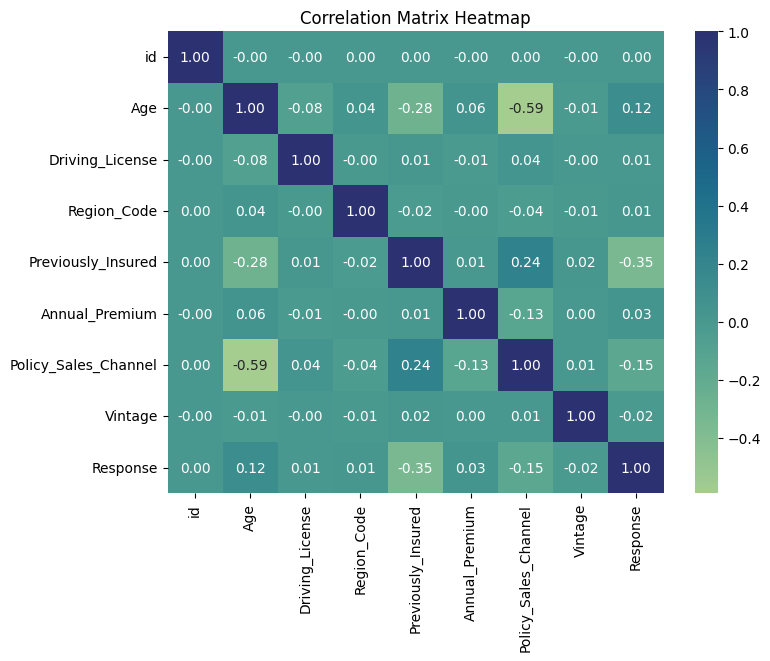

In [32]:
# Select the specified columns
columns_of_interest = ["id", "Age", "Driving_License", "Region_Code", "Previously_Insured", "Annual_Premium", "Policy_Sales_Channel", "Vintage", "Response"]
train_df_selected = train_df[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = train_df_selected.corr()

# Configure the size of the figure
plt.figure(figsize=(8,6))

# Correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

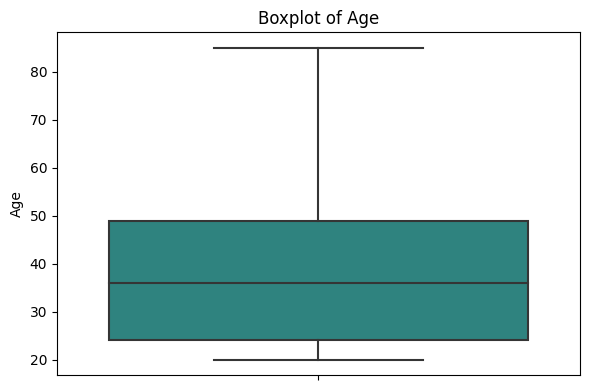

In [33]:
# Select numeric columns
numeric_columns = ["Age"]

# Configure the size of the figure
plt.figure(figsize=(6, 4))  # Adjusted size for a single plot

# Loop to create boxplots for each numeric column
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, len(numeric_columns), i)  # Adjusted to handle single subplot
    sns.boxplot(data=train_df, y=column, palette='viridis')
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.grid(False)
plt.show()

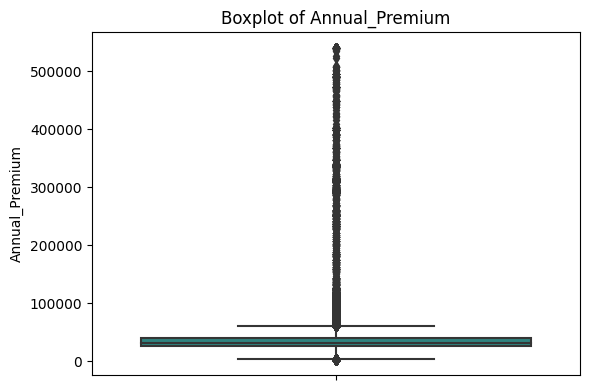

In [34]:
# Select numeric columns
numeric_columns = ["Annual_Premium"]

# Configure the size of the figure
plt.figure(figsize=(6, 4))  # Adjusted size for a single plot

# Loop to create boxplots for each numeric column
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, len(numeric_columns), i)  # Adjusted to handle single subplot
    sns.boxplot(data=train_df, y=column, palette='viridis')
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.grid(False)
plt.show()

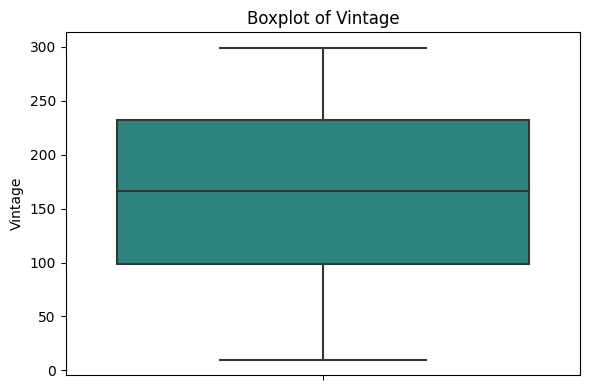

In [35]:
# Select numeric columns
numeric_columns = ["Vintage"]

# Configure the size of the figure
plt.figure(figsize=(6, 4))  # Adjusted size for a single plot

# Loop to create boxplots for each numeric column
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, len(numeric_columns), i)  # Adjusted to handle single subplot
    sns.boxplot(data=train_df, y=column, palette='viridis')
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.grid(False)
plt.show()

# STEP 5:Data Cleaning

In [36]:
#Handling Missing Values
print("Number of missing values ​​per column:")
print(train_df.isnull().sum())

Number of missing values ​​per column:
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
Age_Bucket              0
dtype: int64


In [37]:
train_df.shape

(11504798, 13)

In [38]:
# Select numeric columns
numeric_columns = ["Age", "Annual_Premium", "Vintage"]

# Function to remove outliers using IQR
def remove_outliers(train_df, columns):
    for columns in columns:
        Q1 = train_df[column].quantile(0.25)
        Q3 = train_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        train_df = train_df[(train_df[column] >= lower_bound) & (train_df[column] <= upper_bound)]
        return train_df

# Remove outliers from the DataFrame
df_cleaned = remove_outliers(train_df, numeric_columns)

# Check the DataFrame dimension after removing outliers
print(f"Original dimension: {train_df.shape}")
print(f"Dimension after removing outliers: {df_cleaned.shape}")

# View the first records of the cleaned DataFrame
df_cleaned.head()

Original dimension: (11504798, 13)
Dimension after removing outliers: (11504798, 13)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_Bucket
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0,18-25
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1,36-50
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0,18-25
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0,26-35
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0,36-50


In [39]:
import pandas as pd
import numpy as np

def optimize_memory_usage(df_cleaned):
    """
    Optimizes the memory usage of a pandas DataFrame by converting categorical columns
    and adjusting the precision of numerical columns.
    
    Parameters:
    df_cleaned (pd.DataFrame): DataFrame to be optimized.
    
    Returns:
    pd.DataFrame: Optimized DataFrame.
    """
    # View memory usage before optimization
    print("Memory usage before optimization:")
    print(df_cleaned.memory_usage(deep=True))
    print()
    
    # Converting categorical columns to dtype 'category'
    categorical_columns = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 
                           'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 
                           'Response', 'Age_Bucket']
    
    for col in categorical_columns:
        if col in df_cleaned.columns:
            df_cleaned[col] = df_cleaned[col].astype('category')
    
    # Adjusting precision of integer columns
    numeric_columns = df_cleaned.select_dtypes(include=np.number).columns
    
    for col in numeric_columns:
        if df_cleaned[col].dtype == np.int64:
            # Example of dynamic precision adjustment
            if df_cleaned[col].max() < 2**7:  # 0 to 127
                df_cleaned[col] = df_cleaned[col].astype('int8')
            elif df_cleaned[col].max() < 2**15:  # 0 to 32,767
                df_cleaned[col] = df_cleaned[col].astype('int16')
            elif df_cleaned[col].max() < 2**31:  # 0 to 2,147,483,647
                df_cleaned[col] = df_cleaned[col].astype('int32')
            else:
                df_cleaned[col] = df_cleaned[col].astype('int64')
    
    # View memory usage after applying conversions
    print("Memory usage after applying conversions:")
    print(df_cleaned.memory_usage(deep=True))
    
    # Check detailed memory usage
    print(df_cleaned.info(memory_usage='deep'))
    print()
    
    return df_cleaned

# Assuming `df_cleaned`, `test_df`, and `df` are already defined DataFrames
df_cleaned_optimized_train = optimize_memory_usage(df_cleaned)
test_df_optimized_test = optimize_memory_usage(test_df)
df_optimized = optimize_memory_usage(train_df)


Memory usage before optimization:
Index                         128
id                       92038384
Gender                  712346006
Age                      92038384
Driving_License          92038384
Region_Code              92038384
Previously_Insured       92038384
Vehicle_Age             748289845
Vehicle_Damage          684566311
Annual_Premium           92038384
Policy_Sales_Channel     92038384
Vintage                  92038384
Response                 92038384
Age_Bucket               11505216
dtype: int64

Memory usage after applying conversions:
Index                        128
id                      46019192
Gender                  11505030
Age                     11504798
Driving_License         11504922
Region_Code             11507334
Previously_Insured      11504922
Vehicle_Age             11505102
Vehicle_Damage          11505025
Annual_Premium          92038384
Policy_Sales_Channel    23014980
Vintage                 23009596
Response                11504922
Age_Bu

In [40]:
def optimize_memory_usage(df_cleaned):
    """
    Optimizes the memory usage of a pandas DataFrame by converting categorical columns
    and adjusting the precision of numerical columns.
    
    Parameters:
    df_cleaned (pd.DataFrame): DataFrame to be optimized.
    
    Returns:
    pd.DataFrame: Optimized DataFrame.
    """
    # View memory usage before optimization
    print("Memory usage before optimization:")
    print(df_cleaned.memory_usage(deep=True))
    print()
    
    # Converting categorical columns to dtype 'category'
    categorical_columns = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 
                           'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 
                           'Response', 'Age_Bucket']
    
    for col in categorical_columns:
        if col in df_cleaned.columns:
            df_cleaned[col] = df_cleaned[col].astype('category')
    
    # Reducing precision of integers
    # Assuming age is within 0 to 127
    if 'Age' in df_cleaned.columns:
        df_cleaned['Age'] = df_cleaned['Age'].astype('int8')
    
    # Adjust according to maximum value for Annual_Premium
    if 'Annual_Premium' in df_cleaned.columns:
        df_cleaned['Annual_Premium'] = df_cleaned['Annual_Premium'].astype('int32')
    
    # Assuming the value is within the range of int16 for Vintage
    if 'Vintage' in df_cleaned.columns:
        df_cleaned['Vintage'] = df_cleaned['Vintage'].astype('int16')
    
    # View memory usage after applying conversions
    print("Memory usage after applying conversions:")
    print(df_cleaned.memory_usage(deep=True))
    
    # Check detailed memory usage
    print(df_cleaned.info(memory_usage='deep'))
    print()
    return df_cleaned

# Optimizing the DataFrames
df_cleaned_optimized_train = optimize_memory_usage(df_cleaned)
test_df_optimized_test = optimize_memory_usage(test_df)
df_optimized = optimize_memory_usage(train_df)

Memory usage before optimization:
Index                        128
id                      46019192
Gender                  11505030
Age                     11504798
Driving_License         11504922
Region_Code             11507334
Previously_Insured      11504922
Vehicle_Age             11505102
Vehicle_Damage          11505025
Annual_Premium          92038384
Policy_Sales_Channel    23014980
Vintage                 23009596
Response                11504922
Age_Bucket              11505216
dtype: int64

Memory usage after applying conversions:
Index                        128
id                      46019192
Gender                  11505030
Age                     11504798
Driving_License         11504922
Region_Code             11507334
Previously_Insured      11504922
Vehicle_Age             11505102
Vehicle_Damage          11505025
Annual_Premium          46019192
Policy_Sales_Channel    23014980
Vintage                 23009596
Response                11504922
Age_Bucket          

In [41]:
# Copy dataset
train_df = df_cleaned_optimized_train.copy()
test_df = df_optimized.copy()

In [42]:
#Handling Missing Values
print("Number of missing values ​​per column:")
print(df_optimized.isnull().sum())

Number of missing values ​​per column:
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
Age_Bucket              0
dtype: int64


In [43]:
print("DataFrame shape:", df_optimized.shape)
print("Missing values per column:")
print(df_optimized.isnull().sum())


DataFrame shape: (11504798, 13)
Missing values per column:
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
Age_Bucket              0
dtype: int64


In [44]:
pip install missingno


Note: you may need to restart the kernel to use updated packages.


<Figure size 1200x800 with 0 Axes>

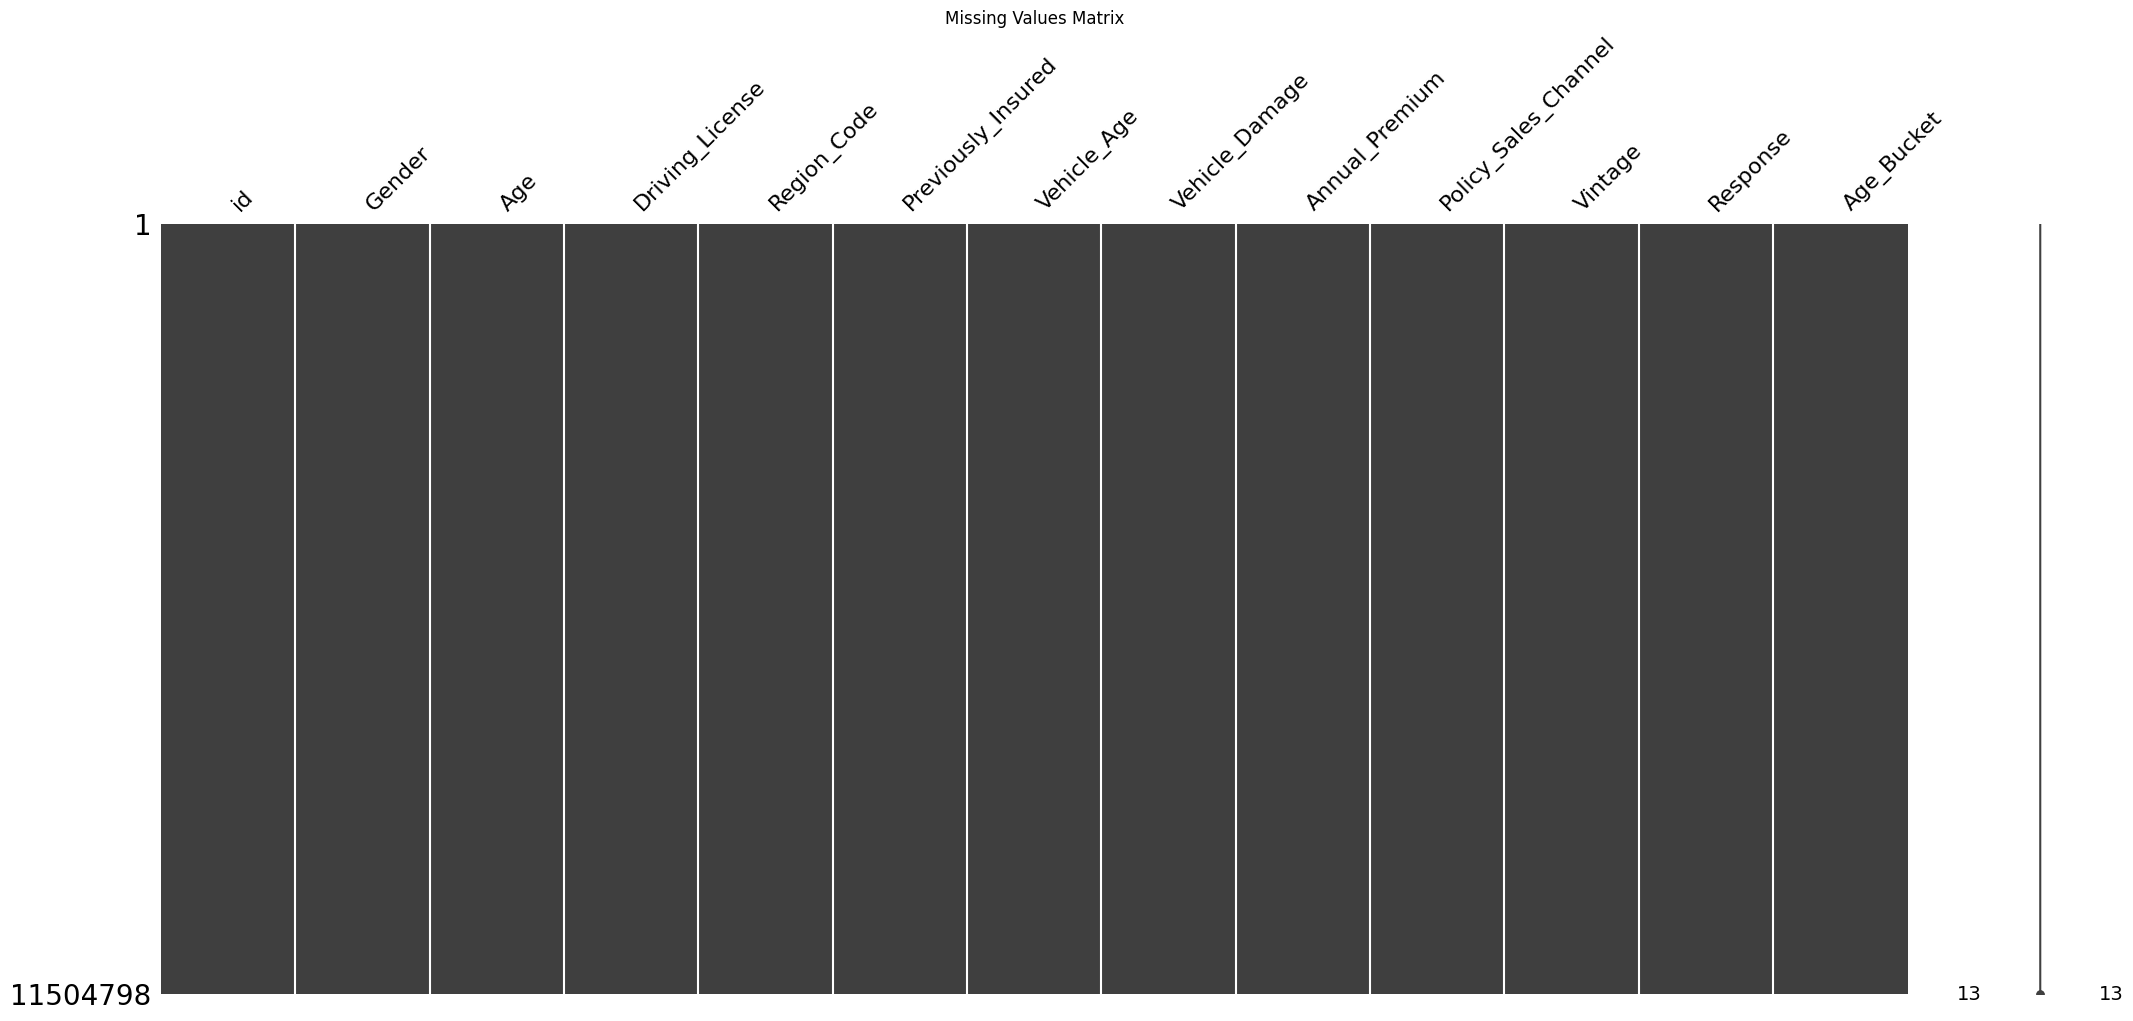

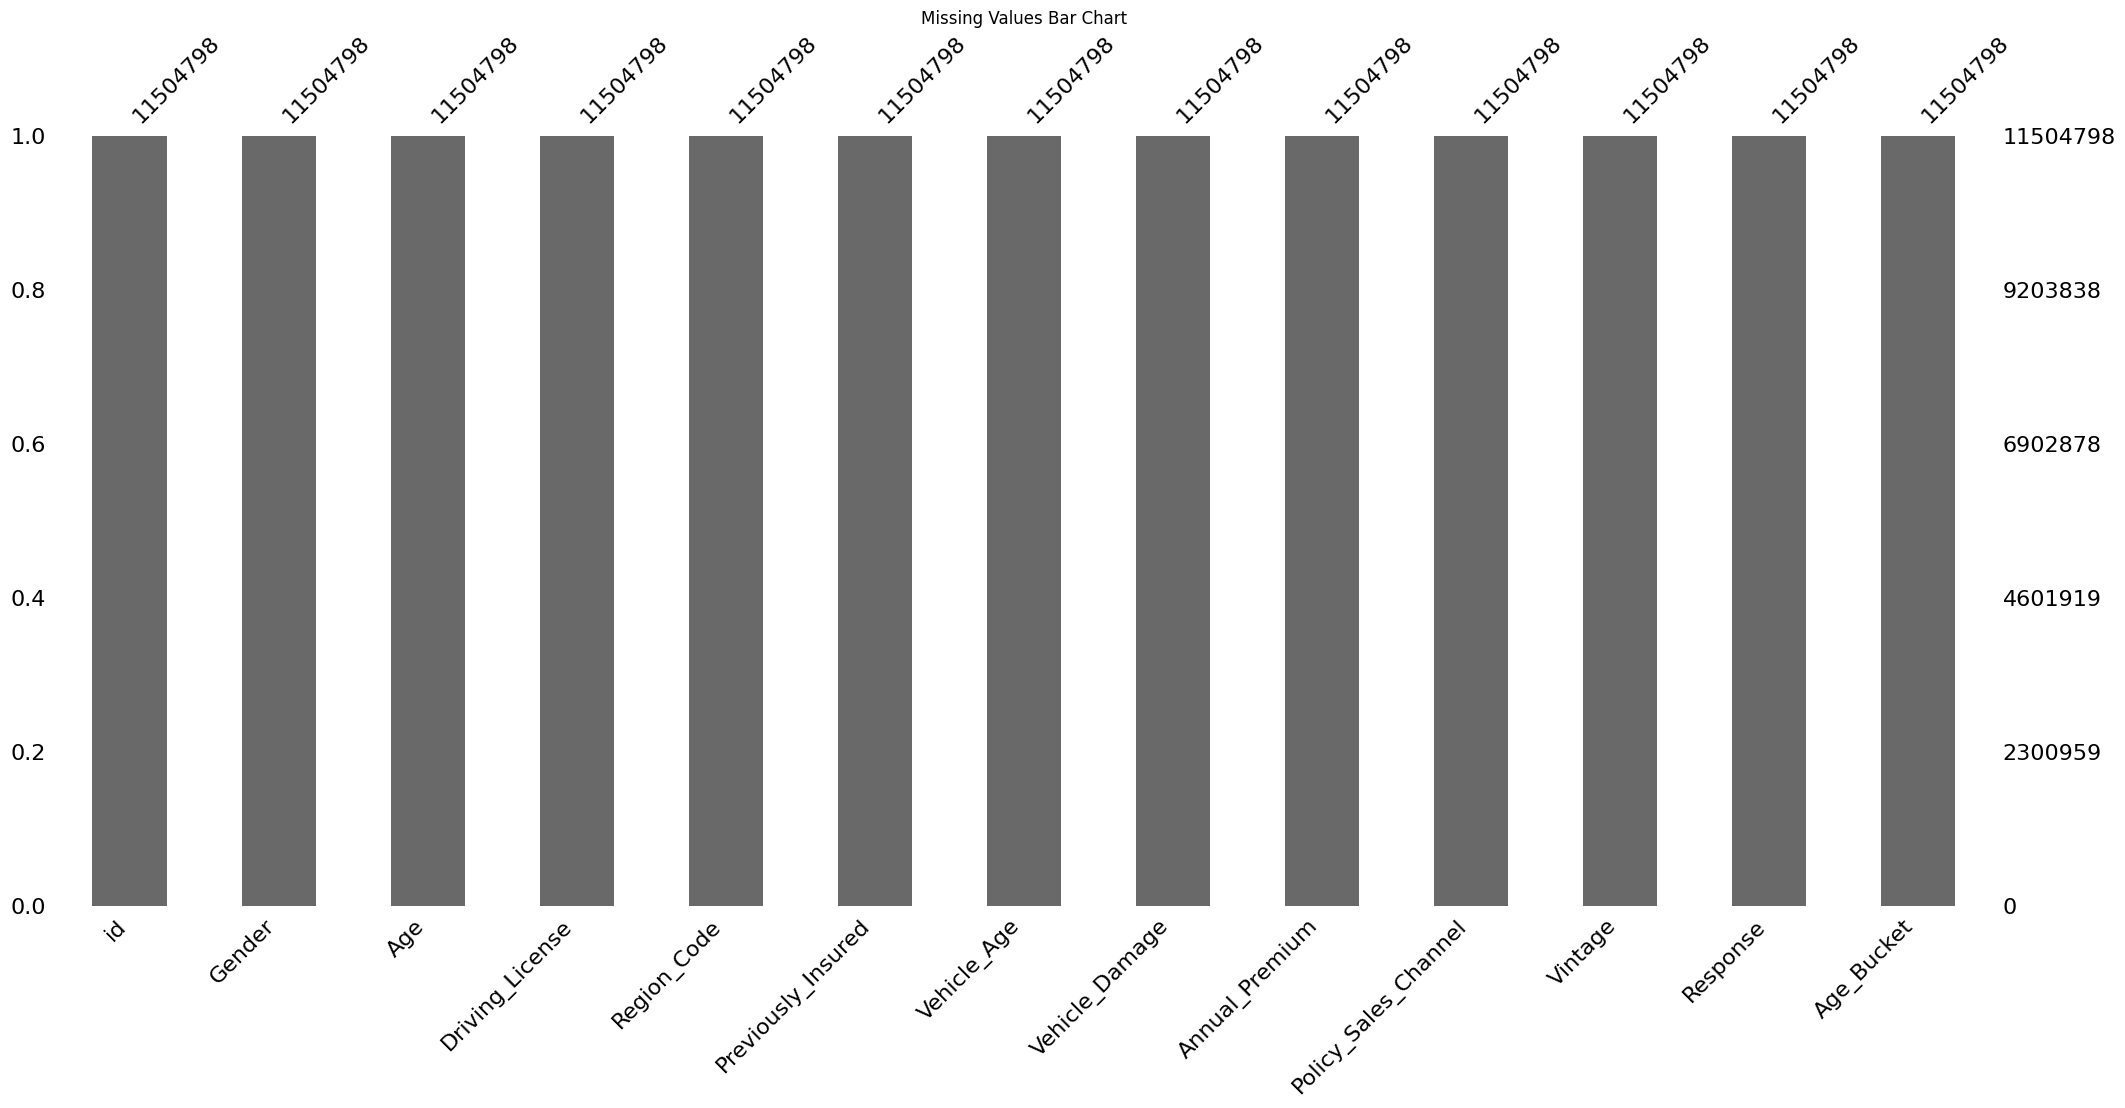

In [45]:
import missingno as msno
import matplotlib.pyplot as plt

# Plot missing values matrix
plt.figure(figsize=(12, 8))
msno.matrix(df_optimized)
plt.title('Missing Values Matrix')
plt.show()

# Plot missing values bar chart
plt.figure(figsize=(12, 8))
msno.bar(df_optimized)
plt.title('Missing Values Bar Chart')
plt.show()


In [46]:

# Importing library
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
label_encoder = LabelEncoder()
df_optimized['Gender'] = label_encoder.fit_transform(df_optimized['Gender'])
df_optimized['Vehicle_Age'] = label_encoder.fit_transform(df_optimized['Vehicle_Age'])
df_optimized['Vehicle_Damage'] = label_encoder.fit_transform(df_optimized['Vehicle_Damage'])

# Viewing
label_encoder# XGBoost model prediction


LabelEncoder()

In [47]:
df_optimized

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_Bucket
0,0,1,21,1,35.0,0,0,1,65101,124.0,187,0,18-25
1,1,1,43,1,28.0,0,2,1,58911,26.0,288,1,36-50
2,2,0,25,1,14.0,1,1,0,38043,152.0,254,0,18-25
3,3,0,35,1,1.0,0,0,1,2630,156.0,76,0,26-35
4,4,0,36,1,15.0,1,0,0,31951,152.0,294,0,36-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,1,48,1,6.0,0,0,1,27412,26.0,218,0,36-50
11504794,11504794,0,26,1,36.0,0,1,1,29509,152.0,115,1,26-35
11504795,11504795,0,29,1,32.0,1,1,0,2630,152.0,189,0,26-35
11504796,11504796,0,51,1,28.0,0,0,1,48443,26.0,274,1,51+


In [48]:
# Fill missing values
df_optimized.fillna(method='ffill', inplace=True)
df_optimized.fillna(method='ffill', inplace=True)

In [49]:
# Resources
X = df_optimized.drop(columns=['Response'])  

# Target variable
y = df_optimized['Response']  


In [50]:
# Viewing rows and columns x
X.shape

(11504798, 12)

In [51]:

# Viewing rows and columns
y.shape

(11504798,)

In [52]:
# Importing libraries
from sklearn.model_selection import train_test_split

# Training and testing division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Viewing training data
print("Viewing rows and columns given by X train", X_train.shape)

# Viewing test data

print("Viewing rows and columns given y train", y_train.shape)

Viewing rows and columns given by X train (9203838, 12)
Viewing rows and columns given y train (9203838,)


In [53]:
# Converting categorical columns to dummy variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Viewing training data
print("Viewing rows and columns given by X train", X_train.shape)

# Viewing test data
print("Viewing rows and columns given y train", y_train.shape)

Viewing rows and columns given by X train (9203838, 221)
Viewing rows and columns given y train (9203838,)
